# ロジスティック回帰

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# cpu がどんな感じで動いているか？
jax.devices()

[CpuDevice(id=0)]

In [3]:
df = pd.DataFrame({
    'gas': [1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.861, 1.8839],
    'beetles': [59, 60, 62, 56, 63, 59, 62, 60],
    'deaths': [6, 13, 18, 28, 52, 53, 61, 60]
})

データ：「有毒ガスを充満させたとき、そこにいたカブトムシが何匹死ぬか？」

Text(0, 0.5, 'Death Rate')

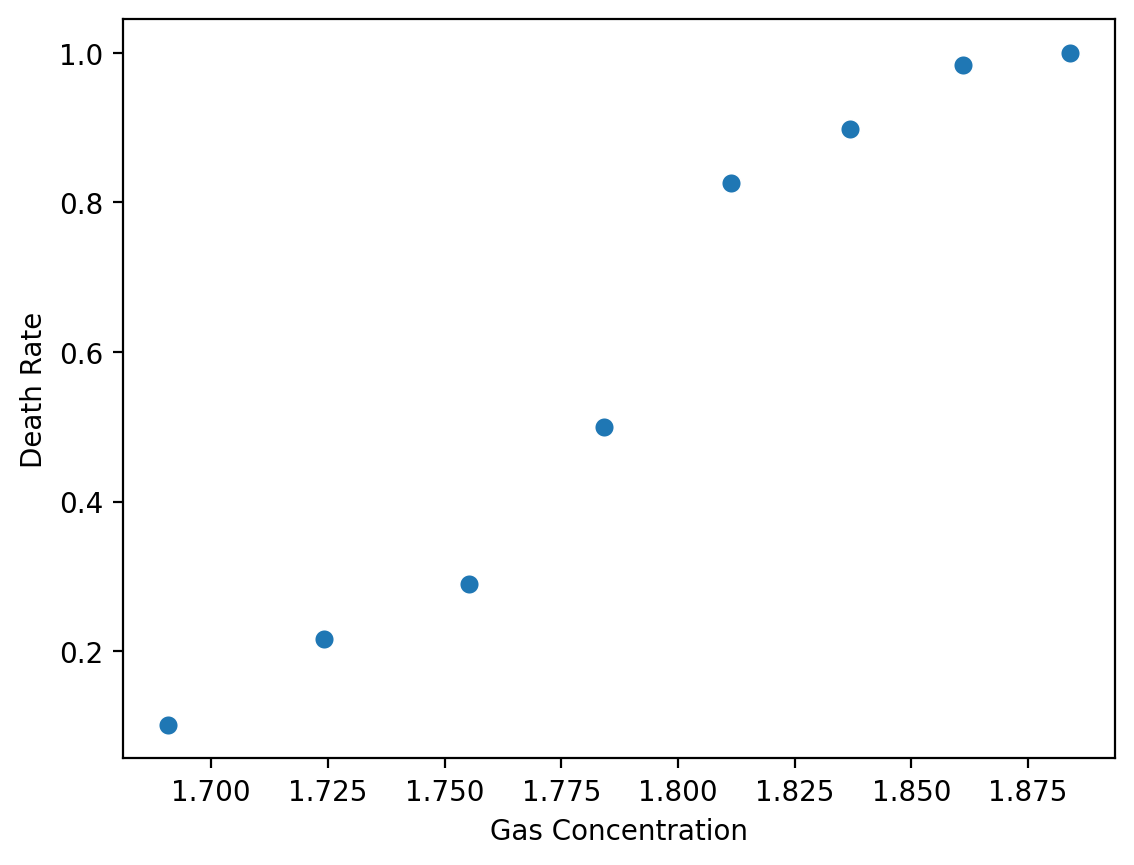

In [4]:
sns.scatterplot(x = df['gas'], y = df['deaths'] / df['beetles'], s = 50)

plt.xlabel("Gas Concentration")
plt.ylabel("Death Rate")

In [7]:
gas = df['gas'].values
deaths = df['deaths'].values
beetles = df['beetles'].values

回帰の場合は標準化

In [8]:
gas_mu = np.mean(gas)
gas_sd = np.std(gas)

gas_scaled = (gas - gas_mu) / gas_sd

グラフでは `death rate` として示したが、モデルの中では割り算をせずに offset項 を利用する 

In [9]:
def model(gas_scaled = None, deaths = None, beetles = None, num_data = 0):

    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))

    mu = a * gas_scaled + b
    theta = jax.nn.sigmoid(mu)

    with numpyro.plate('plate_obs', num_data):
        numpyro.sample('obs', dist.Binomial(total_count = beetles, probs = theta), obs = deaths)

In [10]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(42), gas_scaled = gas_scaled, deaths = deaths, beetles = beetles, num_data = len(gas_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_3352/3031639514.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00


In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

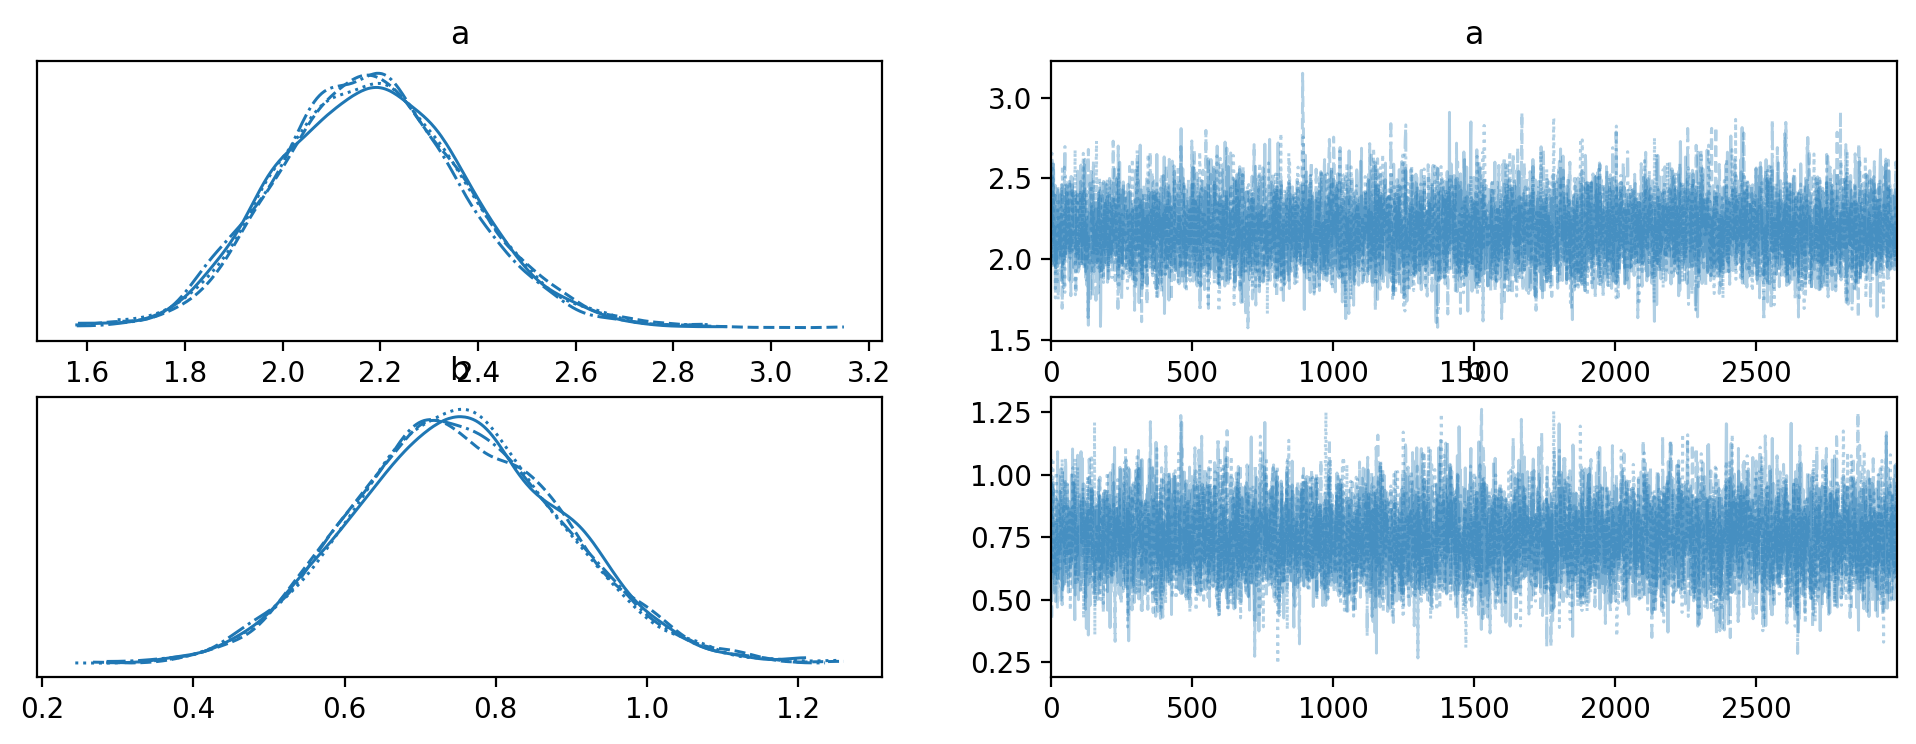

In [12]:
az.plot_trace(idata)

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.181,0.188,1.831,2.528,0.002,0.002,6866.0,6529.0,1.0
b,0.749,0.139,0.497,1.017,0.002,0.001,6624.0,6504.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

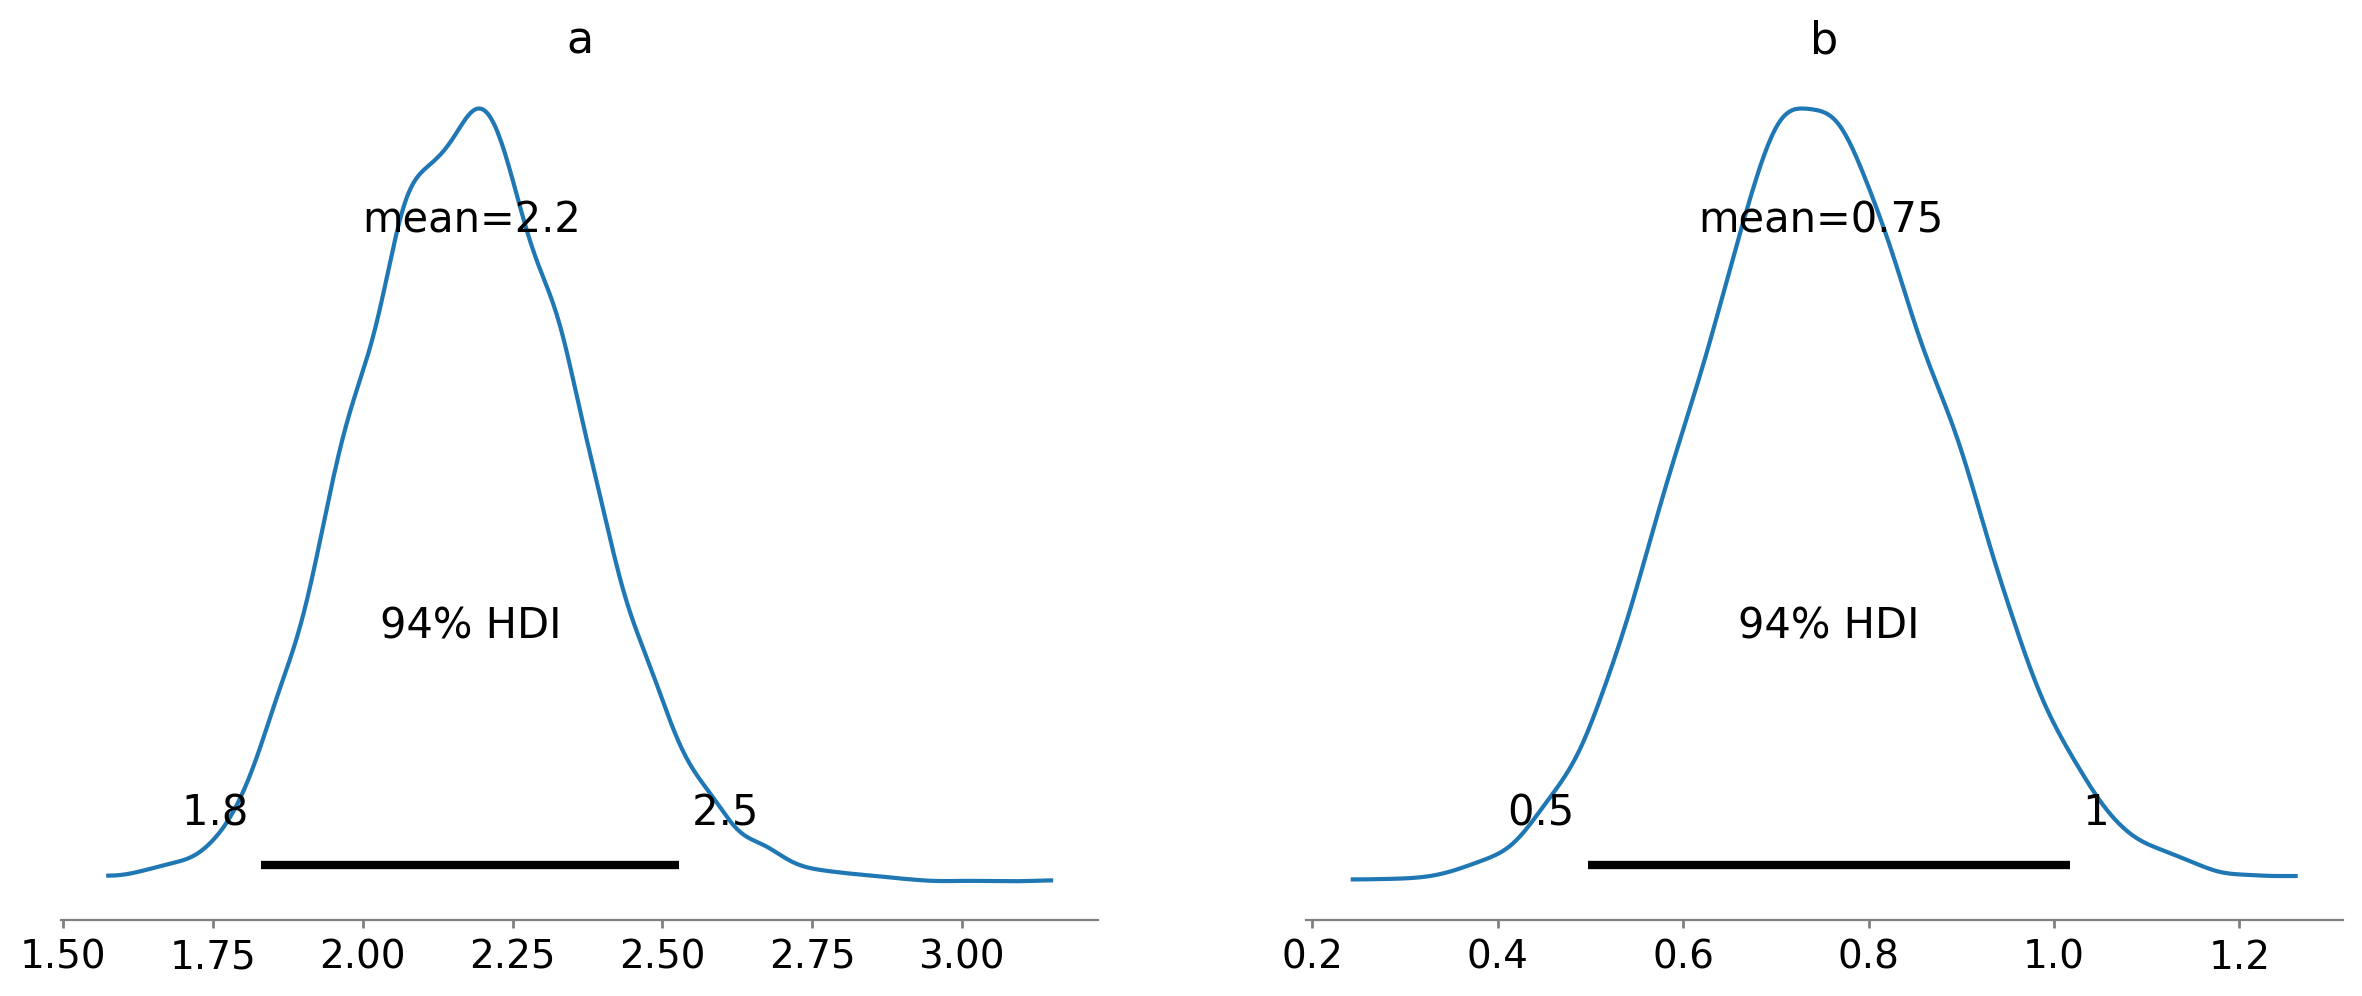

In [14]:
az.plot_posterior(idata)

In [79]:
def plot_curves(trace):
    
    samples_to_plot = 10
    x_scaled_new = np.linspace(-2, 2, 100)

    for k in range(1, samples_to_plot):
        a_sample = trace['a'][-k]  # 最新の10本を取ってきたいからマイナス
        b_sample = trace['b'][-k]
    
        mu = a_sample * x_scaled_new + b_sample
    
        p = 1 / (1 + np.exp(-mu))
    
        plt.plot(x_scaled_new, p, c = 'g', alpha = 0.2)

Text(0, 0.5, 'Death Rate')

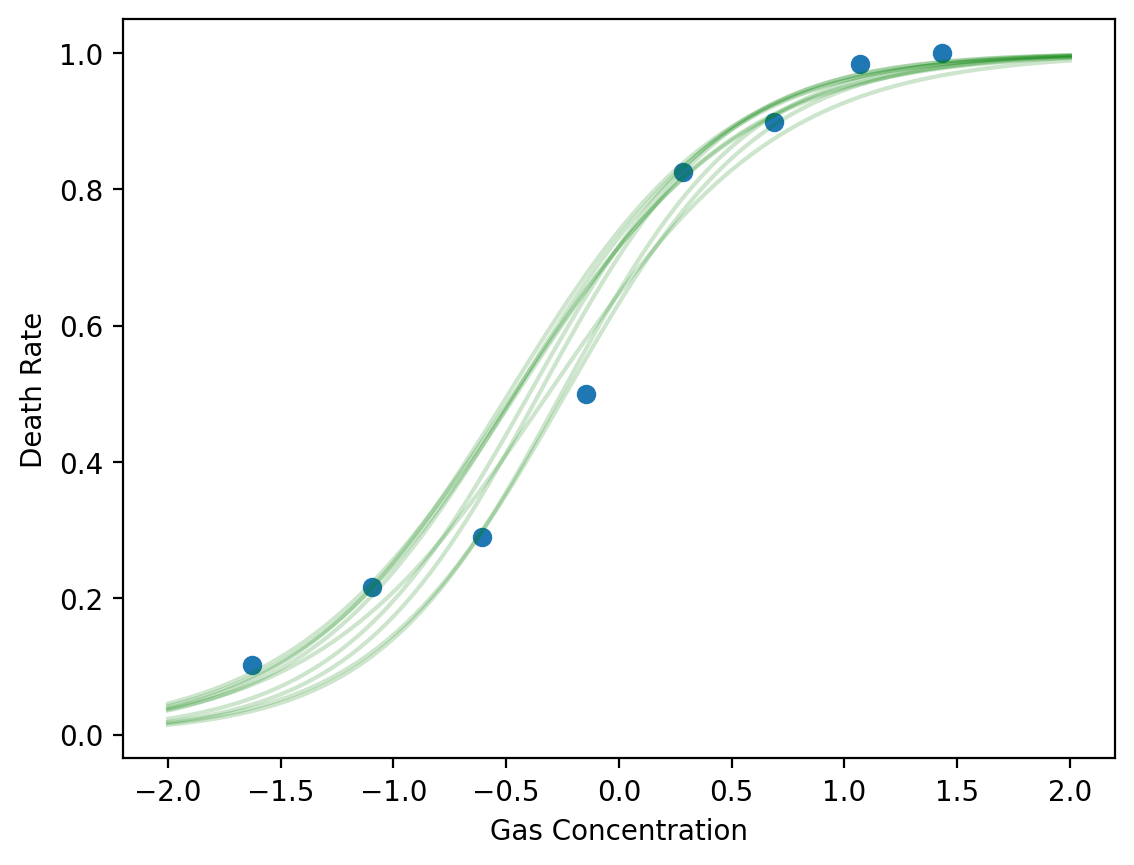

In [80]:
plt.scatter(gas_scaled, deaths / beetles)
plot_curves(mcmc_samples)

plt.xlabel("Gas Concentration")
plt.ylabel("Death Rate")

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [28]:
%%time
# 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する

predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(42), gas_scaled = gas_scaled, beetles = beetles, num_data = len(gas_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

CPU times: user 644 ms, sys: 12.3 ms, total: 656 ms
Wall time: 645 ms


In [29]:
ppc_samples['obs'].shape

(12000, 8)

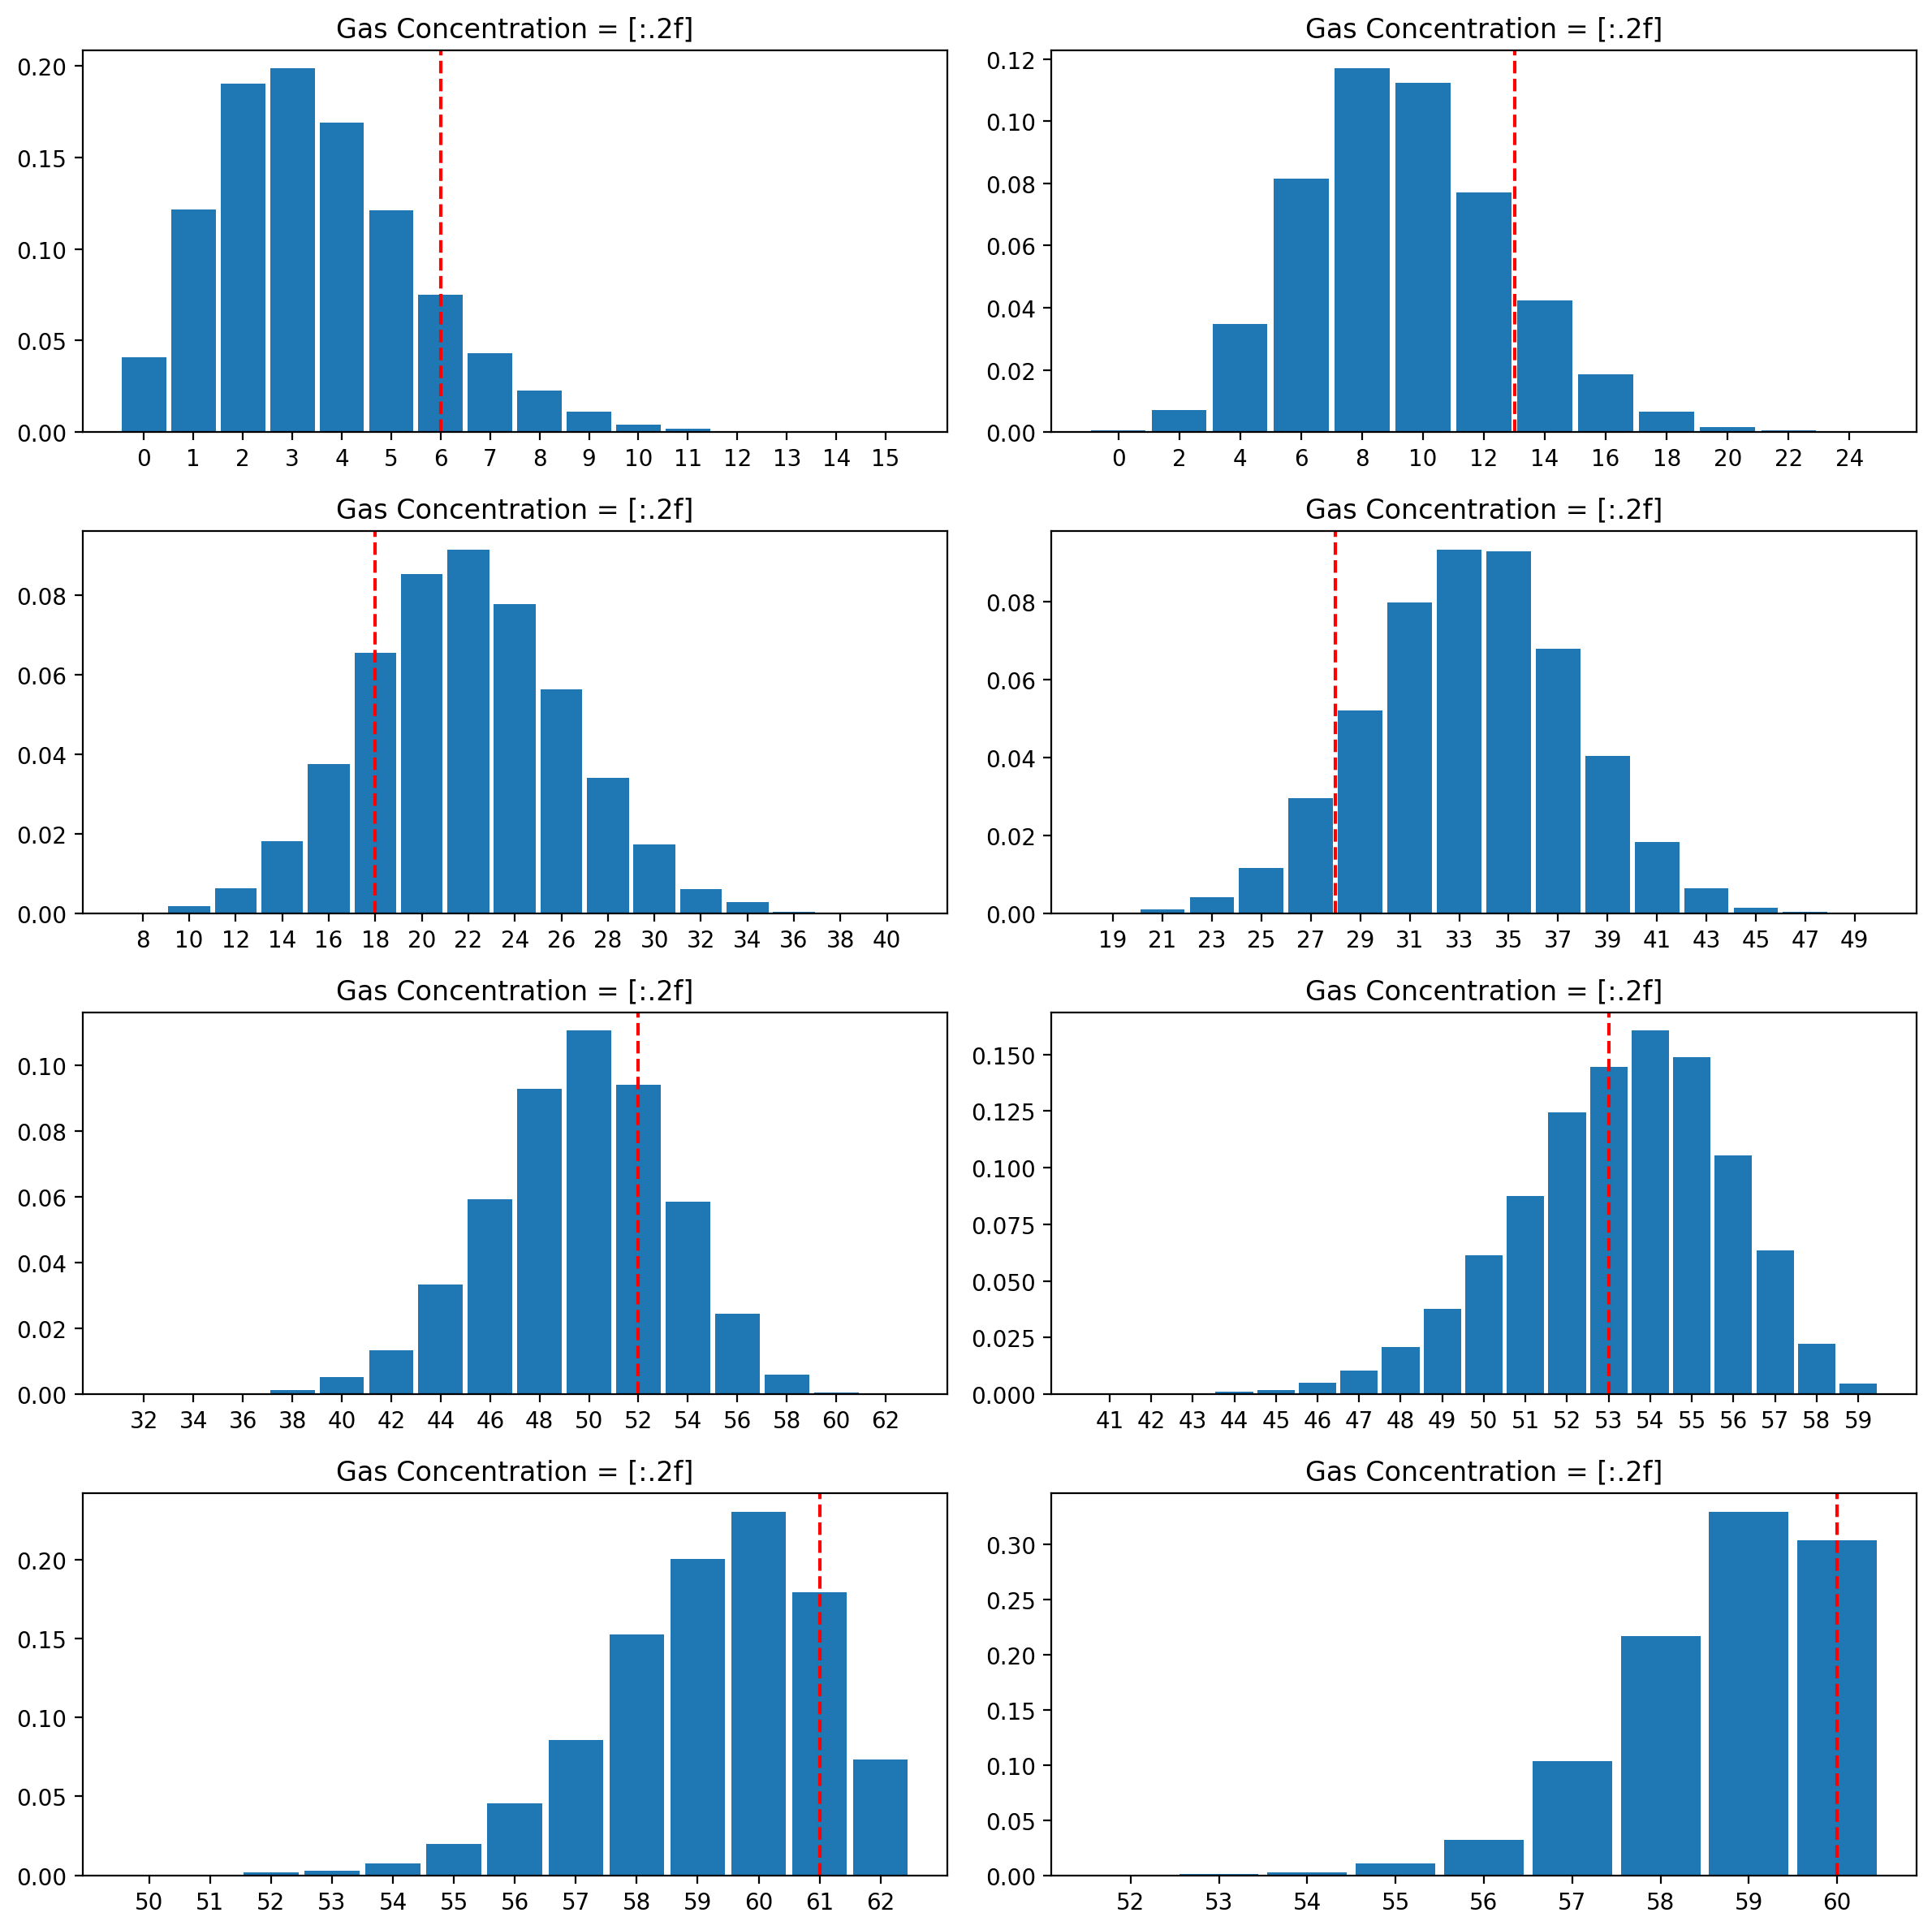

In [91]:
fig = plt.figure(figsize = (12, 12))

for k in range(8):
        
    ax = fig.add_subplot(4, 2, k+1)

    az.plot_dist(ppc_samples['obs'][:, k]) # ppc_samples の　obs なので mcmc で作ったサンプル(実際の観測データ8個に対して)
    ax.axvline(deaths[k], color = 'r', linestyle = 'dashed') # deaths　は実際の観測データ（8個）
    ax.set_title("Gas Concentration = [:.2f]".format(gas[k]))

plt.tight_layout()

**解釈**：結果としては概ね良さそう
> + すごく外れたデータはなくモデルがデータをうまく表現できている<br>
> + 外れ値もなさそう）